## Extending the SIR model in starsim to SEIRS

The `starsim` package already implements **SIR**, we will extend this to include the exposed compartment.


In [43]:
"""
The code is adopted from https://github.com/starsimhub/starsim/blob/ae4f4a92b268d19e86cc80f9f53e93b53fcc5698/starsim/diseases/measles.py#L92
"""

import numpy as np
import starsim as ss
from starsim.diseases.sir import SIR

__all__ = ['Meningitis']

class Meningitis(SIR):

    def __init__(self, pars=None, par_dists=None, *args, **kwargs):
        """
        Initialize with parameters
        """
        pars = ss.omergeleft(pars,
            dur_exp = 2,        # (days)
            dur_inf = 7,        # (days)
            p_death = 0.05,    # (prob of death) 
            init_prev = 0.005, # Init cond
            beta = 0.1,         # Init cond
            waning = 0.05,
            imm_boost = ss.lognorm_ex(1, 1)
        )
        
        par_dists = ss.omergeleft(par_dists,
            dur_exp   = ss.normal,
            dur_inf   = ss.normal,
            init_prev = ss.bernoulli,
            p_death   = ss.bernoulli,
        )

        super().__init__(pars=pars, par_dists=par_dists, *args, **kwargs)
        # SIR are added automatically, here we add E
        self.add_states(
            ss.State('exposed', bool, False),
            ss.State('ti_exposed', float, np.nan),
            ss.State('ti_recovered', float, np.nan),
            ss.State('immunity', float, 0.0),
        )
        return

    def init_results(self, sim):
        """ Initialize results """
        super().init_results(sim)
        self.results += ss.Result(self.name, 'rel_sus', sim.npts, dtype=float)
        self.results += ss.Result(self.name, 'new_recoveries', sim.npts, dtype=float)
        self.results += ss.Result(self.name, 'recovered', sim.npts, dtype=float)
        return

    def update_results(self, sim):
        """ Store the population immunity (susceptibility) """
        super().update_results(sim)
        self.results['rel_sus'][sim.ti] = self.rel_sus.mean()
        self.results['new_recoveries'][sim.ti] = np.count_nonzero(self.ti_recovered == sim.ti)
        self.results['recovered'][sim.ti] = np.count_nonzero(self.immunity > 0.5)

        return 

    @property
    def infections(self):
        return self.infected | self.exposed

    def update_pre(self, sim):
        # Progress exposed -> infected
        infected = ss.true(self.exposed & (self.ti_infected <= sim.ti))
        self.exposed[infected] = False
        self.infected[infected] = True

        # Progress infected -> recovered
        recovered = ss.true(self.infected & (self.ti_recovered <= sim.ti))
        self.infected[recovered] = False
        self.susceptible[recovered] = True

        # Progress recovered -> susceptible
        # susceptible = ss.true(self.recovered & (self.ti_recovered <= sim.ti))
        # self.recovered[susceptible] = False
        # self.susceptible[susceptible] = True
        self.update_immunity(sim)

        # Trigger deaths
        deaths = ss.true(self.ti_dead <= sim.ti)
        if len(deaths):
            sim.people.request_death(deaths)
        return

    def update_immunity(self, sim):
        uids = ss.true(self.immunity > 0)
        self.immunity[uids] = (self.immunity[uids])*(1 - self.pars.waning*sim.dt)
        self.rel_sus[uids] = np.maximum(0, 1 - self.immunity[uids])
        return

    def set_prognoses(self, sim, uids, source_uids=None):
        """ Set prognoses for those who get infected """
        # Do not call set_prognosis on parent
        # super().set_prognoses(sim, uids, source_uids)

        self.susceptible[uids] = False
        self.exposed[uids] = True
        self.ti_exposed[uids] = sim.ti

        p = self.pars
        self.immunity[uids] += p.imm_boost.rvs(uids)

        # Determine when exposed become infected
        self.ti_infected[uids] = sim.ti + p.dur_exp.rvs(uids) / sim.dt

        # Sample duration of infection, being careful to only sample from the
        # distribution once per timestep.
        dur_inf = p.dur_inf.rvs(uids)
        
        # Determine who dies and who recovers and when
        will_die = p.p_death.rvs(uids)
        dead_uids = uids[will_die]
        rec_uids = uids[~will_die]
        self.ti_dead[dead_uids] = self.ti_infected[dead_uids] + dur_inf[will_die] / sim.dt
        self.ti_recovered[rec_uids] = self.ti_infected[rec_uids] + dur_inf[~will_die] / sim.dt

        return

    def update_death(self, sim, uids):
        # Reset infected/recovered flags for dead agents
        for state in ['susceptible', 'exposed', 'infected', 'recovered']:
            self.statesdict[state][uids] = False
        return



Initializing sim with 10000 agents
  Running 0.0 ( 0/101) (0.15 s)  ———————————————————— 1%
  Running 10.0 (10/101) (0.29 s)  ••—————————————————— 11%
  Running 20.0 (20/101) (0.36 s)  ••••———————————————— 21%
  Running 30.0 (30/101) (0.45 s)  ••••••—————————————— 31%
  Running 40.0 (40/101) (0.49 s)  ••••••••———————————— 41%
  Running 50.0 (50/101) (0.55 s)  ••••••••••—————————— 50%
  Running 60.0 (60/101) (0.65 s)  ••••••••••••———————— 60%
  Running 70.0 (70/101) (0.74 s)  ••••••••••••••—————— 70%
  Running 80.0 (80/101) (0.82 s)  ••••••••••••••••———— 80%
  Running 90.0 (90/101) (0.93 s)  ••••••••••••••••••—— 90%
  Running 100.0 (100/101) (0.99 s)  •••••••••••••••••••• 100%



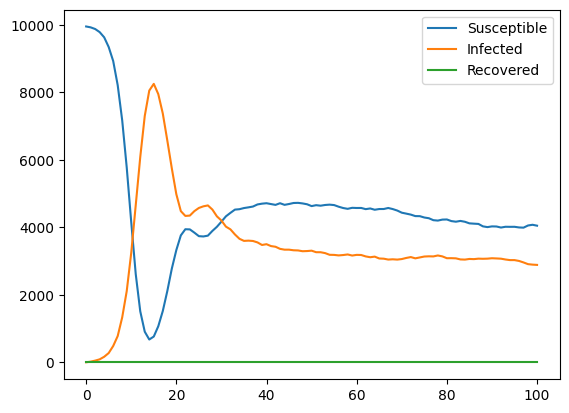

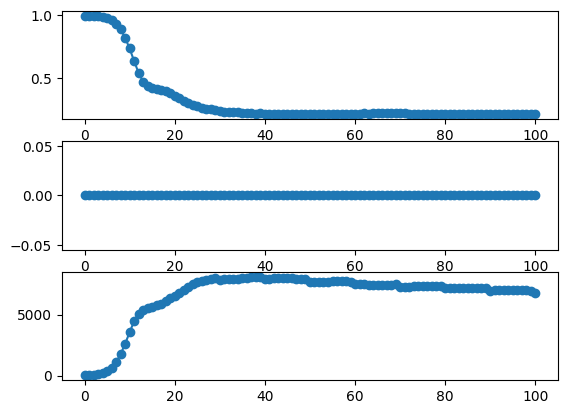

In [44]:
meningitis = Meningitis(beta=0.1, waning=0.05)
pars = dict(networks='random', start=0, end=100, dt=1)
sim = ss.Sim(pars, diseases=meningitis)
sim.run()
sim.diseases.meningitis.plot()

# Pull out results related to population immunity
time = sim.yearvec
import pylab as pl
pl.figure()
pl.subplot(3,1,1)
pl.plot(time, sim.results.meningitis.rel_sus, 'o-')
pl.subplot(3,1,2)
pl.plot(time, sim.results.meningitis.new_recoveries, 'o-')
pl.subplot(3,1,3)
pl.plot(time, sim.results.meningitis.recovered, 'o-')
pl.show()


In [45]:
import pylab as pl
def plot_more(sim, var, add = False, nrow=2, ncol=2, figsize=(8, 8)):
    if (ncol*nrow)>len(var):
        ncol = 1
        nrow = len(var)
    fig, axs = pl.subplots(nrow, ncol, figsize=figsize)
    for i, ax in enumerate(axs.flatten()):
        x = sim.tivec
        if add:
            y =  sim.results.meningitis[var[i]]
        else:
            y = sim.results[var[i]]
        ax.plot(x, y)
        ax.set_title(var[i])
    pl.tight_layout()
    return

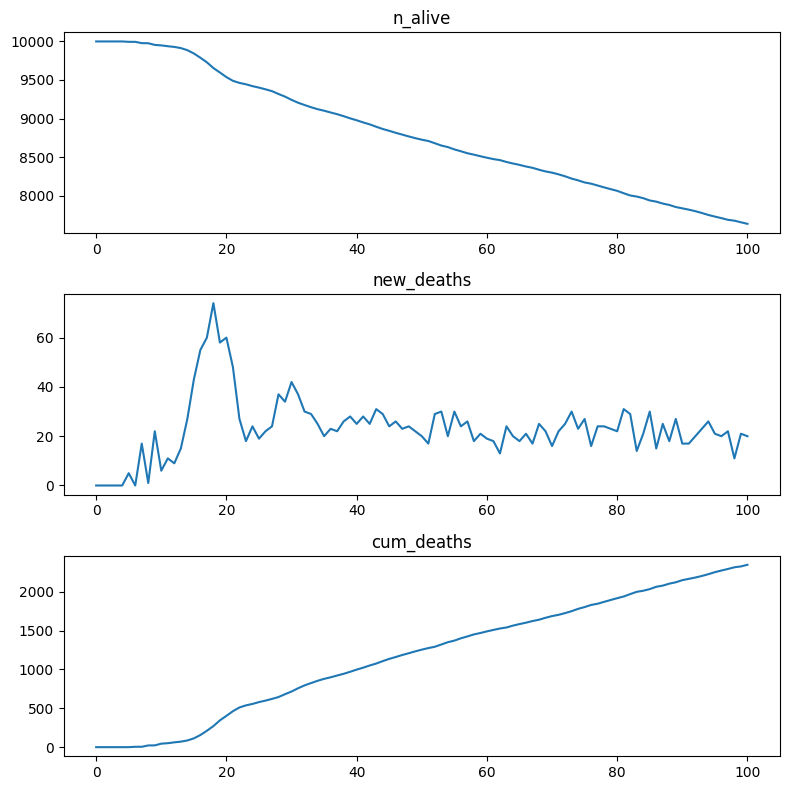

In [46]:
vars = ['n_alive', 'new_deaths', 'cum_deaths']
plot_more(sim, vars,  nrow=2, ncol=2)

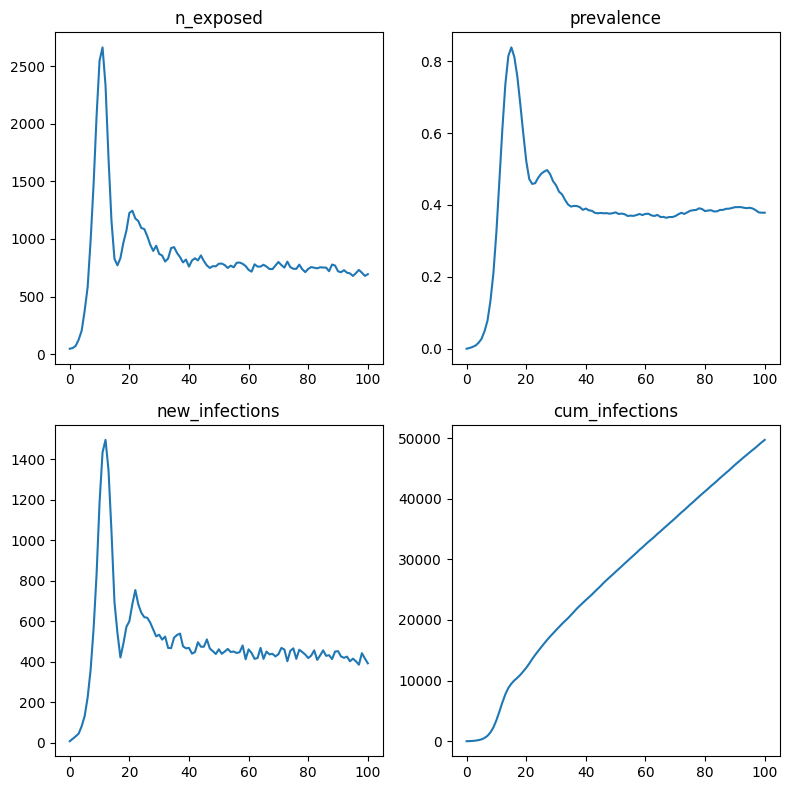

In [47]:
vars = ['n_exposed',
 'prevalence',
 'new_infections',
 'cum_infections']
plot_more(sim, vars, add=True)

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.04 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.18 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.32 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.38 s)  •••••••••••••••••••• 100%

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.05 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.18 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.30 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.39 s)  •••••••••••••••••••• 100%

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.03 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.12 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.20 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.27 s)  •••••••••••••••••••• 100%



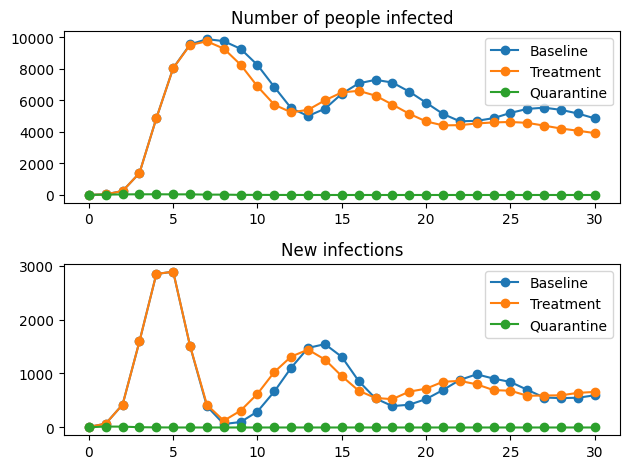

Number of infections averted by treatment: 16068.0
Number of infections averted by quarantine: 175108.0
Percentage of infections averted by treatment: 0.09160514238476668
Percentage of infections averted by quarantine: 0.9983067757475557


In [49]:
import numpy as np # Math
import sciris as sc # Utilities
import pylab as pl # Plotting
import starsim as ss # ABM


class Treatment(ss.Intervention):  # Create a new, generic treatment intervention

    def __init__(self, prob=0.5, mean_dur_infection=5):
        super().__init__() # Initialize the intervention
        self.prob = prob # Store the probability of vaccination
        self.dur_infection = ss.normal(mean_dur_infection, 1)  # Store the duration of infection

    def apply(self, sim):
        meningitis = sim.diseases.meningitis

        # Define  who is eligible for treatment
        eligible_ids = sim.people.uid[meningitis.ti_infected == sim.ti]  # People are eligible for treatment if they have just started exhibiting symptoms
        n_eligible = len(eligible_ids) # Number of people who are eligible

        # Define who receives treatment
        is_treated = np.random.rand(n_eligible) < self.prob  # Define which of the n_eligible people get treated by comparing np.random.rand() to self.p
        treat_ids = eligible_ids[is_treated]  # Pull out the IDs for the people receiving the treatment

        # Treated people will have a new disease progression
        dur_inf = self.dur_infection.rvs(treat_ids)  # Sample duration of infection by generating random variables (RVS) drawn from the distribution of durations

        # Determine who dies and who recovers and when
        will_die = meningitis.pars.p_death.rvs(treat_ids)  # Sample probability of dying
        dead_uids = treat_ids[will_die]  # Pull out the IDs of people who die
        recover_uids = treat_ids[~will_die]  # Pull out the IDs of people who recovery
        meningitis.ti_dead[dead_uids] = meningitis.ti_infected[dead_uids] + dur_inf[will_die] / sim.dt  # Set the time of death
        meningitis.ti_recovered[recover_uids] = meningitis.ti_infected[recover_uids] + dur_inf[~will_die] / sim.dt  # Set the time of recovery


class Quarantine(ss.Intervention):
    def __init__(self, prob=1, rel_trans=0, delay=0):
        super().__init__() # Initialize the intervention
        self.prob = prob # Store the probability of quarantining
        self.rel_trans = rel_trans  # Relative transmissibility of people in quarantine
        self.delay = delay  # Delay between exposure and being put into quarantine

    def apply(self, sim):
        meningitis = sim.diseases.meningitis

        # Define  who is eligible for treatment
        eligible_ids = sim.people.uid[(meningitis.ti_exposed - self.delay) == sim.ti]  # People are eligible for quarantine after a delay 
        n_eligible = len(eligible_ids)  # Number of eligible people

        # Define who is quarantined
        in_quarantine = np.random.rand(n_eligible) < self.prob  # Define which of the n_eligible people are quarantined by comparing np.random.rand() to self.p
        quar_ids = eligible_ids[in_quarantine]  # Pull out the IDs for the people going into quarantine

        # Quarantined people will have a reduced relative transmissibility
        meningitis.rel_trans[quar_ids] = self.rel_trans


def make_run_sim(delay=0, n_contacts=4, beta=0.9, treated_dur_infection=5, do_plot=True, verbose=0.1, seed=4):

    # Make the interventions
    treatment = Treatment(mean_dur_infection=treated_dur_infection)  # Create the specific treatment
    quarantine = Quarantine(delay=delay)  # Create the specific quarantine

    # Make the parameters
    pars = dict(start=0, end=30, dt=1.0, verbose=verbose, rand_seed=seed)  # Define the parameters of the simulation
    n_contacts = n_contacts  # Define the daily number of contacts that a person has
    beta = beta  # Define the probability of an infected person transmitting to a susceptible person

    # In tutorial 5.2, the 'pars' dictionary also oncluded the diseases and the network. It looked like this:
    #    pars = dict(start=0, end=50, dt=1.0, diseases='sis', networks='random')
    # In this tutorial, we will see how to change some of the parameters of the disease and network
    # Rather than putting them in the pars dictionary, we provide them separately to the simulation. 

    # Define "baseline" and "intervention" sims: without any interventions, with treatment, and with quarantine
    baseline = ss.Sim(
        pars, 
        networks=ss.RandomNet(dict(networks='random')),
        diseases = Meningitis(pars=dict(beta=beta))
        )
    treat_sim = ss.Sim(
        pars,
        networks=ss.RandomNet(dict(networks='random')),
        diseases = Meningitis(pars=dict(beta=beta)),
        interventions=treatment
        )
    quar_sim = ss.Sim(
        pars,
        networks=ss.RandomNet(dict(networks='random')),
        diseases = Meningitis(pars=dict(beta=beta)),
        interventions=quarantine
        )

    # Run the three simulations
    baseline.run()
    treat_sim.run()
    quar_sim.run()

    # Pull out results to plot
    tvec = baseline.yearvec
    n_inf_base = baseline.results.meningitis.n_infected
    n_inf_treat = treat_sim.results.meningitis.n_infected
    n_inf_quar = quar_sim.results.meningitis.n_infected

    new_inf_base = baseline.results.meningitis.new_infections
    new_inf_treat = treat_sim.results.meningitis.new_infections
    new_inf_quar = quar_sim.results.meningitis.new_infections

    if do_plot:  # Whether or not to make the plot
        # Create the figure
        pl.figure()

        # Plot number of people infected
        pl.subplot(2,1,1)  # Create the first panel in the plot
        pl.title('Number of people infected')
        pl.plot(tvec, n_inf_base, 'o-', label='Baseline')  # Plot baseline
        pl.plot(tvec, n_inf_treat, 'o-', label='Treatment')  # Plot treatment
        pl.plot(tvec, n_inf_quar, 'o-', label='Quarantine')  # Plot quarantine
        pl.legend()

        # Plot number of new infections
        pl.subplot(2,1,2) # Create the second panel in the plot
        pl.title('New infections')
        pl.plot(tvec, new_inf_base, 'o-', label='Baseline') # Plot baseline
        pl.plot(tvec, new_inf_treat, 'o-', label='Treatment') # Plot treatment
        pl.plot(tvec, new_inf_quar, 'o-', label='Quarantine') # Plot quarantine
        pl.legend()

        sc.figlayout()
        pl.show()

    # Calculate and display the number of infections averted
    averted_by_treatment = n_inf_base.sum() - n_inf_treat.sum()
    averted_by_quarantine = n_inf_base.sum() - n_inf_quar.sum()
    print(f'Number of infections averted by treatment: {averted_by_treatment}')
    print(f'Number of infections averted by quarantine: {averted_by_quarantine}')
    print(f'Percentage of infections averted by treatment: {(averted_by_treatment)/n_inf_base.sum()}')
    print(f'Percentage of infections averted by quarantine: {(averted_by_quarantine)/n_inf_base.sum()}')


# Make, run, and plot the simulation
make_run_sim()


Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.07 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.16 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.22 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.31 s)  •••••••••••••••••••• 100%

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.03 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.14 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.21 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.33 s)  •••••••••••••••••••• 100%

Initializing sim with 10000 agents
  Running 0.0 ( 0/31) (0.03 s)  ———————————————————— 3%
  Running 10.0 (10/31) (0.13 s)  •••••••————————————— 35%
  Running 20.0 (20/31) (0.23 s)  •••••••••••••——————— 68%
  Running 30.0 (30/31) (0.34 s)  •••••••••••••••••••• 100%



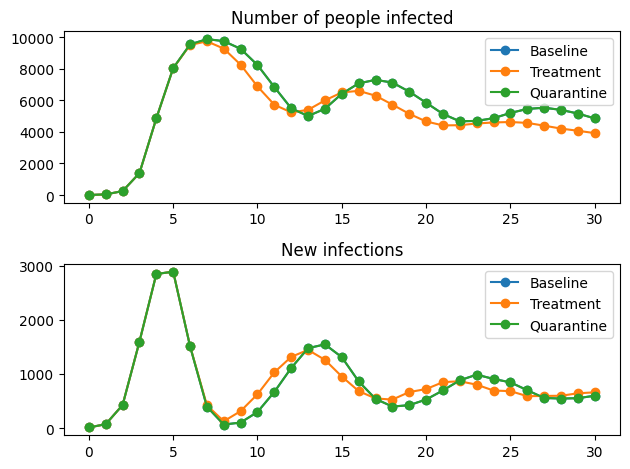

Number of infections averted by treatment: 16068.0
Number of infections averted by quarantine: 0.0
Percentage of infections averted by treatment: 0.09160514238476668
Percentage of infections averted by quarantine: 0.0


In [50]:
make_run_sim(delay=1)

In [51]:
for treated_dur_infection in range(6,11):
    print(f'\n\n\nDuration of infection for treated people: {treated_dur_infection}')
    make_run_sim(treated_dur_infection=treated_dur_infection, do_plot=False, verbose=0, seed=999)




Duration of infection for treated people: 6
Number of infections averted by treatment: 8479.0
Number of infections averted by quarantine: 173871.0
Percentage of infections averted by treatment: 0.04868288089660558
Percentage of infections averted by quarantine: 0.9982947498966515



Duration of infection for treated people: 7
Number of infections averted by treatment: 1930.0
Number of infections averted by quarantine: 173871.0
Percentage of infections averted by treatment: 0.011081254880345413
Percentage of infections averted by quarantine: 0.9982947498966515



Duration of infection for treated people: 8
Number of infections averted by treatment: -3560.0
Number of infections averted by quarantine: 173871.0
Percentage of infections averted by treatment: -0.020440034908823665
Percentage of infections averted by quarantine: 0.9982947498966515



Duration of infection for treated people: 9
Number of infections averted by treatment: -8475.0
Number of infections averted by quarantine: 17